In [ ]:
# Import relevant packaages
import ee
import geemap

In [ ]:
# Initialisie earth engine
ee.Authenticate()
ee.Initialize()

In [ ]:
# magic command to render plots in notebook
%matplotlib inline

### Broadleaf cover

In [ ]:
# Load a polygon of the UK so that we can clip the CORINE dataset
ukPoly = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017') \
         .filter(ee.Filter.eq('country_co', 'UK'))

# Load the Corine landcover categorisation for 2018 (the latest)
# Each pixel represents 100m x 100m or 1 hectare
# Select the landcover band and clip to the UK border
corine = ee.Image('COPERNICUS/CORINE/V20/100m/2018') \
    .select('landcover') \
    .clipToCollection(ukPoly)

# Select pixels that represent Broadleaf categorisation (311)
mask = corine.eq(311)
# Generate a broadleaf image by using the mask for 311
broadleaf = mask.updateMask(mask).multiply(corine)

In [ ]:
# Create a map
Map = geemap.Map()
# Centre on the UK
Map.setCenter(-1.2589, 51.7521, 8)
# Plot the map
Map.addLayer(broadleaf, {'palette' : 'red'}, 'Broadleaf', True)

If we load the administrative boundariies for the Uk, we can plot them and then calculate the percentage of landcover within a county that is broadleaf woodland.

In [ ]:
# Select UK Counties from the GAUL feature collection
# "U.K. of Great Britain and Northern Ireland"

uk = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2") \
              .filter(ee.Filter.eq('ADM0_NAME', "U.K. of Great Britain and Northern Ireland") \
)

Let's visualise the broadleaf woodland and county boundaries

In [ ]:
# Plot map
Map.addLayer(uk, {}, 'uk counties')
Map

What is the total area of broadleaf woodland within the UK? Let's start with the total area of the UK

In [ ]:
# disolve feature collection into single polygon
# then extract area
# convert from m2 to km2
area = uk.geometry().area().getInfo()/1e6
print("Total uk land area: ", area, " km2")

Then we can work out the total area covered by broadleaf woodland

In [ ]:
areaImage = mask.multiply(ee.Image.pixelArea())
area = areaImage.reduceRegion(
    reducer   = ee.Reducer.sum(),
    geometry  = uk.geometry(),
    scale     = 100,
    maxPixels = 1e10
    )

In [ ]:
broadleafCover = area.getInfo()

What is the total area of broadleaf trees iin the UK?

In [ ]:
print("Total uk broadleaf forest area: ", broadleafCover["landcover"] / (1e6), " km2")

### Broadleaf woodland area by UK county

Not let's calculate the percentage broadleaf cover for each UK county, and then order them

In [ ]:
# Define broadleaf mask for UK
ukBroadleafImage = mask.multiply(ee.Image.pixelArea())

# Functionn to map over counties (features) within UK featureCollection
def mapCounties(county):
    
    # Calculate county area and set property
    countyArea = county.geometry().area().divide(1e6).round()
    # Set a property within the county feature to capture the county area
    county = county.set('County_Area', countyArea)
    
    # Calculate broadleaf area within county
    broadleafArea = ukBroadleafImage.reduceRegion(
        reducer   = ee.Reducer.sum(),
        geometry  = county.geometry(),
        scale     = 100,
        maxPixels = 1e10
    ).get("landcover")
    
    # Convert broadleaf area into km2
    broadleafArea = ee.Number.float(broadleafArea).divide(1e6)
    
    # Set a property within the county feature to capture broadleaf area for the county
    county = county.set('Broadleaf_Area', broadleafArea)
    
    # Percentage broadleaf
    percentageBroadleaf = broadleafArea.divide(countyArea).multiply(100)
    # Set a property within the county feature to capture the % broadleaf
    county = county.set('Broadleaf_Per', percentageBroadleaf)

    # return updated feature
    return county
    
# Map over uk counties and calulcate the county area and the broadleaf woodland area within it
broadleafAreaByCounty = uk.map(mapCounties)

In [ ]:
broadleafAreaByCounty.aggregate_sum("Broadleaf_Area").getInfo()

In [ ]:
broadleafByCounty_df = geemap.ee_to_df(broadleafAreaByCounty)

In [ ]:
broadleafByCounty_df[["ADM2_NAME","County_Area","Broadleaf_Area","Broadleaf_Per"]] \
.sort_values("Broadleaf_Per", ascending=False) \
.head(10)

Plot of percentage of broadleaf coverage across the UK

In [ ]:
empty = ee.Image().byte()

# Paint all the county polygon edges with the same number and width, display.
outline = empty.paint(
  featureCollection = broadleafAreaByCounty,
  color = 'Broadleaf_Per'
)
visParams = {
  'palette': ['white', 'green'],
  'min': 0,
  'max': 11,
  'opacity': 1,
}

Map.addLayer(outline, visParams, 'broadleaf coverage')
Map

### Broadleaf connectivity analysis

Broadleaf woods are clearly more dominant in the south east of England. Let's analyse how well connected they are, with the goal of working out how to enhance connectivity between broadleaf habitats, through wildlife friendly land management as per the UK governments *25 year plan for the Environment*

#### Vectorise the broadleaf layer

Let's start with one county, Oxfordshire. by focusing on one county to start with, hopefully the initial analysis easier to understand.

In [101]:
# Generate polygon for Oxfordshire
oxon = uk.filter(ee.Filter.eq('ADM2_NAME', "Oxfordshire"))

# Vectorise all broadleaf pixels in Oxfordshire
vectors = broadleaf.reduceToVectors(
    reducer = ee.Reducer.countEvery(),
    geometry = oxon,
    scale = 100,
    maxPixels = 1e8
)

# Put the result into a feature collection
oxonBroadleaf = ee.FeatureCollection(vectors)

# Now convert into a geopandas data frane
oxonBroadleaf_df = geemap.ee_to_gdf(oxonBroadleaf)
# Set and reproject to OSG36
oxonBroadleaf_df = oxonBroadleaf_df.set_crs(epsg=4326)
oxonBroadleaf_df = oxonBroadleaf_df.to_crs('epsg:27700')

In [132]:
# Let's eyeball the data
oxonBroadleaf_df.head()

,geometry,count,label
0,"POLYGON ((424529.257 196170.443, 424628.068 19...",60,311
1,"POLYGON ((424193.103 207339.909, 424390.719 20...",42,311
2,"POLYGON ((428695.244 180882.898, 428794.054 18...",107,311
3,"MULTIPOLYGON (((423212.696 218099.367, 423245....",35,311
4,"MULTIPOLYGON (((422816.709 216820.087, 422915....",62,311


Looks like we need to first calculate the centroids for each of the woodland regions (polygon regions), before creating a graph to analyse

In [ ]:
# import libraries that we need for further analysis
from libpysal import weights
import matplotlib.pyplot as plt
import networkx as nx
import geopandas
import numpy as np

In [103]:
# calculate centorids for Oxon broadleaf woodlands
centroids = np.column_stack((oxonBroadleaf_df.centroid.x, oxonBroadleaf_df.centroid.y))

In [177]:
## The 7km distance band graph will connect all pairs of points
## that are within 7km from one another. This means that points
## may have different numbers of neighbors.
dist = weights.DistanceBand.from_array(centroids, threshold=5000)

# Convert to a networkx obejct
dist_graph = dist.to_networkx()

# To plot with networkx, we need to merge the nodes back to
# their positions in order to plot in networkx
positions = dict(zip(dist_graph.nodes, centroids))

Now we can draw the graph, given that we connected all node centroids that are within 7.5km of each other. It can be seen that there are two distinct clusters of nodes that result from this strategy.

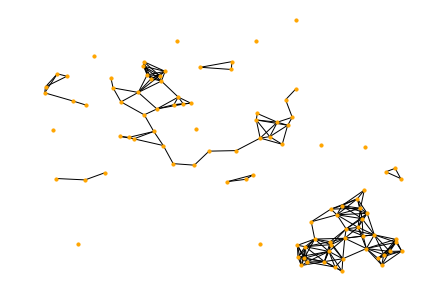

In [178]:
nx.draw(dist_graph, positions, node_size=10, node_color="orange")

In [170]:
knn5 = weights.KNN.from_dataframe(oxonBroadleaf_df,k=4)

In [171]:
knn_graph = knn5.to_networkx()
positions = dict(zip(knn_graph.nodes, centroids))

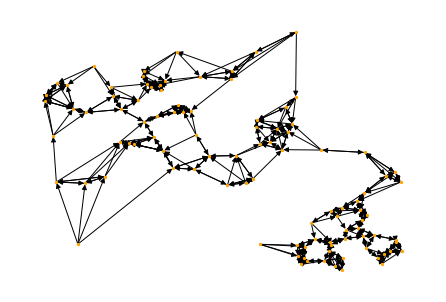

In [172]:
nx.draw(knn_graph, positions, node_size=5, node_color="orange")